# VGG16 Based Model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil
import json

In [2]:
zip_path = '/content/archive.zip'
extract_path = '/content/dataset'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Ekstraksi berhasil!")
else:
    print("Error: archive.zip tidak ditemukan. Silakan upload file terlebih dahulu.")

Ekstraksi berhasil!


## Menggabungkan Data Augmented dan Original

In [3]:
original_base = '/content/dataset/Potato Disease Recognition Dataset/Original Images/Original Images'
augmented_base = '/content/dataset/Potato Disease Recognition Dataset/Augmented Images/Augmented Images'
combined_base = '/content/combined_dataset'

classes = [
    'Potato Soft Rot Disease',
    'Potato Dry Rot Disease',
    'Potato Brown Rot Disease',
    'Healthy Potato',
    'Blackspot Bruising Disease'
]

for cls in classes:
    os.makedirs(os.path.join(combined_base, cls), exist_ok=True)
    orig_folder = os.path.join(original_base, cls)
    aug_folder = os.path.join(augmented_base, f"Augmented {cls}")

    if os.path.exists(orig_folder):
        for img in os.listdir(orig_folder):
            shutil.copy(os.path.join(orig_folder, img), os.path.join(combined_base, cls, f"orig_{img}"))
    if os.path.exists(aug_folder):
        for img in os.listdir(aug_folder):
            shutil.copy(os.path.join(aug_folder, img), os.path.join(combined_base, cls, f"aug_{img}"))

print("Dataset siap digunakan.")

Dataset siap digunakan.


## Preprocessing

In [4]:
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

Found 3960 files belonging to 5 classes.
Using 3168 files for training.
Found 3960 files belonging to 5 classes.
Using 792 files for validation.


## Membangun Model ResNet

In [5]:
from tensorflow.keras.applications import ResNet50

# 1. Load ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze base model agar bobot asli Imagenet tidak berubah
resnet_base.trainable = False

# 3. Build Model menggunakan Functional API (Lebih stabil untuk ResNet)
inputs = tf.keras.Input(shape=(224, 224, 3))

# ResNet50 memiliki fungsi preprocessing internal sendiri
x = tf.keras.applications.resnet50.preprocess_input(inputs)

x = resnet_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Pengganti Flatten, jauh lebih ringan
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train Model

In [6]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.7001 - loss: 0.9599 - val_accuracy: 0.8990 - val_loss: 0.2653
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.8948 - loss: 0.2721 - val_accuracy: 0.9331 - val_loss: 0.1859
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9358 - loss: 0.1777 - val_accuracy: 0.9432 - val_loss: 0.1430
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9446 - loss: 0.1448 - val_accuracy: 0.9432 - val_loss: 0.1473
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9660 - loss: 0.1099 - val_accuracy: 0.9672 - val_loss: 0.1098
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9680 - loss: 0.0954 - val_accuracy: 0.9609 - val_loss: 0.1076
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9715 - loss: 0.0780 - val_accuracy: 0.9684 - val_loss: 0.0838
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9753 - loss: 0.0681 - val_accur

## Evaluasi

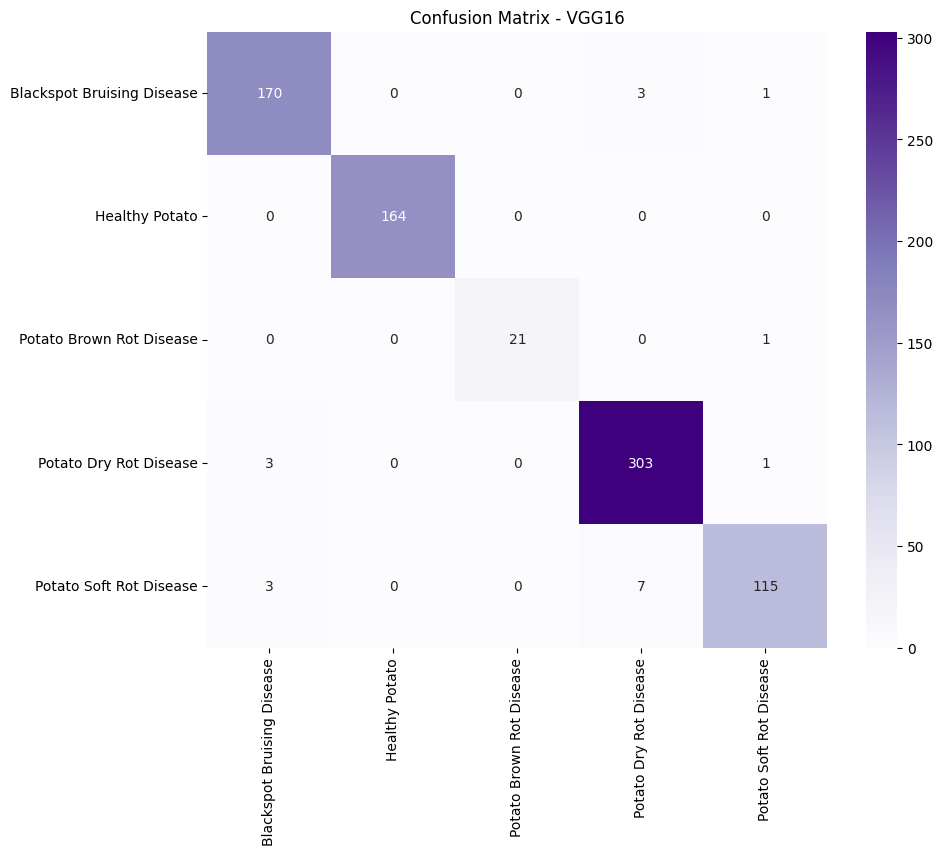


Classification Report:
                             precision    recall  f1-score   support

Blackspot Bruising Disease       0.97      0.98      0.97       174
            Healthy Potato       1.00      1.00      1.00       164
  Potato Brown Rot Disease       1.00      0.95      0.98        22
    Potato Dry Rot Disease       0.97      0.99      0.98       307
   Potato Soft Rot Disease       0.97      0.92      0.95       125

                  accuracy                           0.98       792
                 macro avg       0.98      0.97      0.97       792
              weighted avg       0.98      0.98      0.98       792



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - VGG16')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

## Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


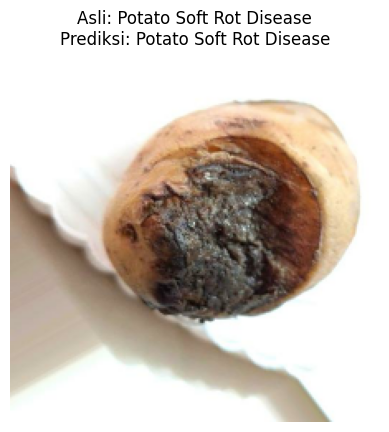

In [11]:
images, labels = next(iter(val_ds))
idx = np.random.randint(0, len(images))

test_img = images[idx].numpy().astype("uint8")
img_array = tf.expand_dims(images[idx], 0)
prediction = model.predict(img_array)
pred_class = class_names[np.argmax(prediction)]

plt.imshow(test_img)
plt.title(f"Asli: {class_names[labels[idx]]}\nPrediksi: {pred_class}")
plt.axis('off')
plt.show()

## Save Model

In [12]:
# Simpan sebagai .keras
model.save('potato_resnet_model.keras')

from google.colab import files
files.download('potato_resnet_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>